### Problem Statement and Justification

Our project aims to identify key characteristics of games on the Steam platform that correlate with high user ratings and positive reception. This can help game developers prioritize features and design choices that improve user satisfaction. Beyond this, we aim to critically assess whether our model's predictions promote features associated with unhealthy player behavior (e.g., grindy loops, pay-to-win mechanics) or exhibit bias toward certain genres or communities. The end goal is to build a model that is both predictive and ethically aware.

### Import Packages

In [112]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from collections import Counter
from sklearn.preprocessing import MultiLabelBinarizer, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier

### Data Cleaning/Preparation and EDA

In [97]:
# Import file and skip issue lines
df = pd.read_csv("games.csv", on_bad_lines='skip')

# Check shape and preview
print(df.shape)
df.head()

(111452, 39)


,AppID,Name,Release date,Estimated owners,Peak CCU,Required age,Price,DiscountDLC count,About the game,Supported languages,...,Average playtime two weeks,Median playtime forever,Median playtime two weeks,Developers,Publishers,Categories,Genres,Tags,Screenshots,Movies
20200,Galactic Bowling,"Oct 21, 2008",0 - 20000,0,0,19.99,0,0,Galactic Bowling is an exaggerated and stylize...,['English'],...,0,0,0,Perpetual FX Creative,Perpetual FX Creative,"Single-player,Multi-player,Steam Achievements,...","Casual,Indie,Sports","Indie,Casual,Sports,Bowling",https://cdn.akamai.steamstatic.com/steam/apps/...,http://cdn.akamai.steamstatic.com/steam/apps/2...
655370,Train Bandit,"Oct 12, 2017",0 - 20000,0,0,0.99,0,0,THE LAW!! Looks to be a showdown atop a train....,"['English', 'French', 'Italian', 'German', 'Sp...",...,0,0,0,Rusty Moyher,Wild Rooster,"Single-player,Steam Achievements,Full controll...","Action,Indie","Indie,Action,Pixel Graphics,2D,Retro,Arcade,Sc...",https://cdn.akamai.steamstatic.com/steam/apps/...,http://cdn.akamai.steamstatic.com/steam/apps/2...
1732930,Jolt Project,"Nov 17, 2021",0 - 20000,0,0,4.99,0,0,Jolt Project: The army now has a new robotics ...,"['English', 'Portuguese - Brazil']",...,0,0,0,Campião Games,Campião Games,Single-player,"Action,Adventure,Indie,Strategy",NaN,https://cdn.akamai.steamstatic.com/steam/apps/...,http://cdn.akamai.steamstatic.com/steam/apps/2...
1355720,Henosis™,"Jul 23, 2020",0 - 20000,0,0,5.99,0,0,HENOSIS™ is a mysterious 2D Platform Puzzler w...,"['English', 'French', 'Italian', 'German', 'Sp...",...,0,0,0,Odd Critter Games,Odd Critter Games,"Single-player,Full controller support","Adventure,Casual,Indie","2D Platformer,Atmospheric,Surreal,Mystery,Puzz...",https://cdn.akamai.steamstatic.com/steam/apps/...,http://cdn.akamai.steamstatic.com/steam/apps/2...
1139950,Two Weeks in Painland,"Feb 3, 2020",0 - 20000,0,0,0.00,0,0,ABOUT THE GAME Play as a hacker who has arrang...,"['English', 'Spanish - Spain']",...,0,0,0,Unusual Games,Unusual Games,"Single-player,Steam Achievements","Adventure,Indie","Indie,Adventure,Nudity,Violent,Sexual Content,...",https://cdn.akamai.steamstatic.com/steam/apps/...,http://cdn.akamai.steamstatic.com/steam/apps/2...


In [98]:
# General info
df.info()

# Check missing values
df.isnull().sum()

# Descriptive statistics
df.describe(include='all')

# Number of unique values per column
df.nunique()

<class 'pandas.core.frame.DataFrame'>
Index: 111452 entries, 20200 to 3183790
Data columns (total 39 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   AppID                       111446 non-null  object 
 1   Name                        111452 non-null  object 
 2   Release date                111452 non-null  object 
 3   Estimated owners            111452 non-null  int64  
 4   Peak CCU                    111452 non-null  int64  
 5   Required age                111452 non-null  float64
 6   Price                       111452 non-null  int64  
 7   DiscountDLC count           111452 non-null  int64  
 8   About the game              104969 non-null  object 
 9   Supported languages         111452 non-null  object 
 10  Full audio languages        111452 non-null  object 
 11  Reviews                     10624 non-null   object 
 12  Header image                111452 non-null  object 
 13  Website       

,0
AppID,110325
Name,4939
Release date,14
Estimated owners,1760
Peak CCU,19
Required age,756
Price,43
DiscountDLC count,98
About the game,104404
Supported languages,14861


In [99]:
# Drop sparse/unnecessary columns
df.drop(columns=[
    'Notes', 'Metacritic url', 'Support email', 'Support url',
    'Header image', 'Website', 'Score rank', 'Movies', 'Screenshots'
], inplace=True, errors='ignore')

# Parse dates
df['Release date'] = df['Release date'].apply(pd.to_datetime, errors='coerce')

# Fill missing game descriptors
for col in ['Developers', 'Publishers', 'Genres', 'Categories', 'Tags']:
    df[col] = df[col].fillna('Unknown')

# Fix scores
df['User score'] = df['User score'].replace(0, pd.NA)
df['Metacritic score'] = df['Metacritic score'].replace(0, pd.NA)

# Drop games with no scores on either end
df = df[(df['User score'].notna()) | (df['Metacritic score'].notna())]

### Create target column for well-recieved

In [100]:
# Calculate total reviews
df['Total_Reviews'] = df['Positive'] + df['Negative']

# Filter for enough reviews
df_filtered = df[df['Total_Reviews'] >= 10].copy()

# Calculate positive review ratio
df_filtered['Pos_Ratio'] = df_filtered['Positive'] / df_filtered['Total_Reviews']

# Replace zeros or missing with NaN for Metacritic and User score
df_filtered['Metacritic score'].replace(0, pd.NA, inplace=True)
df_filtered['User score'].replace(0, pd.NA, inplace=True)

# Define thresholds
pos_ratio_thresh = 0.7
metacritic_thresh = 70
user_score_thresh = 80

# Create boolean columns if thresholds met
df_filtered['Pos_Received'] = df_filtered['Pos_Ratio'] >= pos_ratio_thresh
df_filtered['Metacritic_Received'] = df_filtered['Metacritic score'] >= metacritic_thresh
df_filtered['UserScore_Received'] = df_filtered['User score'] >= user_score_thresh

# Combine - well received if at least 2 out of 3 criteria met
df_filtered['Well_Received'] = (
    df_filtered[['Pos_Received', 'Metacritic_Received', 'UserScore_Received']].sum(axis=1) >= 2
).astype(int)

# Check distribution
print(df_filtered['Well_Received'].value_counts(normalize=True))

target = df_filtered['Well_Received']

Well_Received
1    0.611
0    0.389
Name: proportion, dtype: float64


<ipython-input-100-18164ff885d2>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Total_Reviews'] = df['Positive'] + df['Negative']
<ipython-input-100-18164ff885d2>:11: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_filtered['Metacritic score'].replace(0, pd.NA, inplace=True)
<ipyt

### Visualize the data

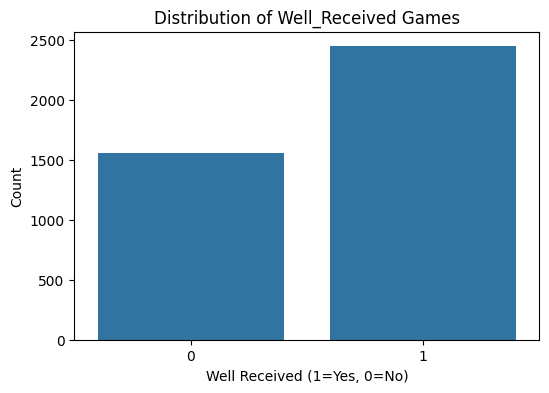

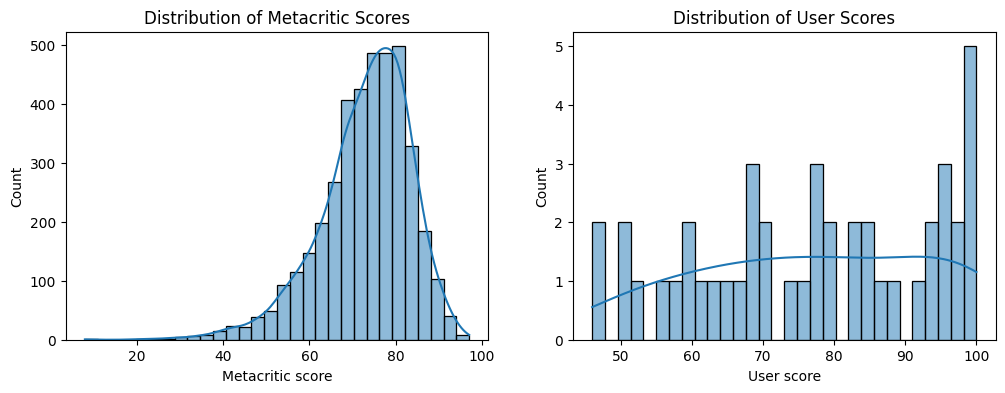

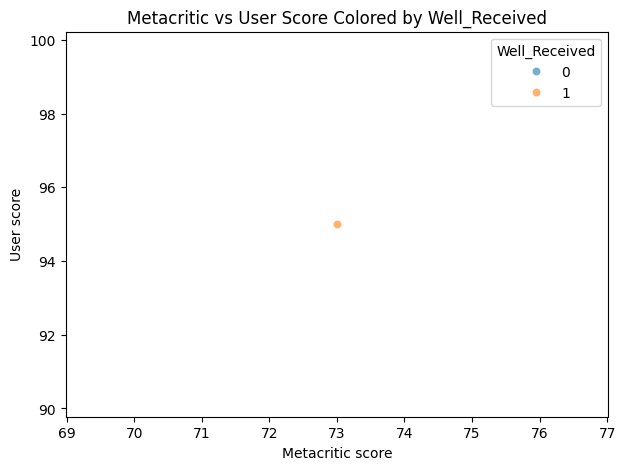

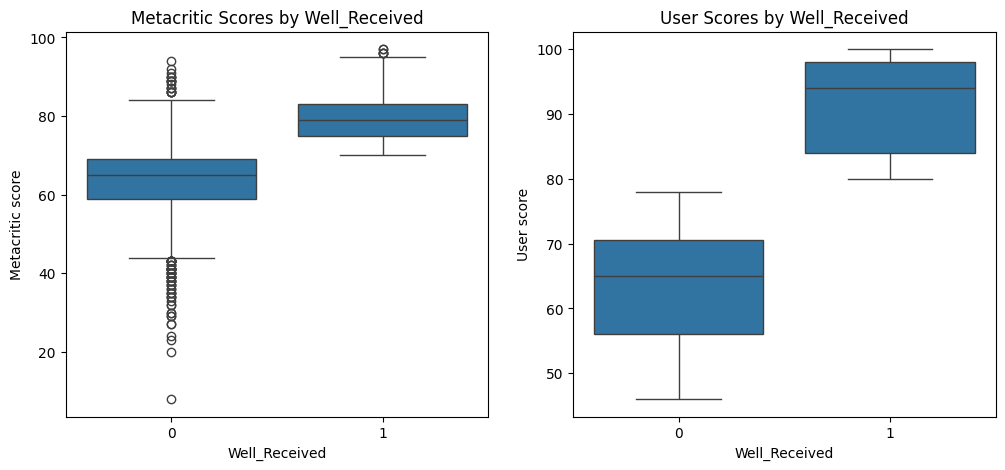

<ipython-input-101-30cc00cde62a>:42: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_genres.values, y=top_genres.index, palette='viridis')


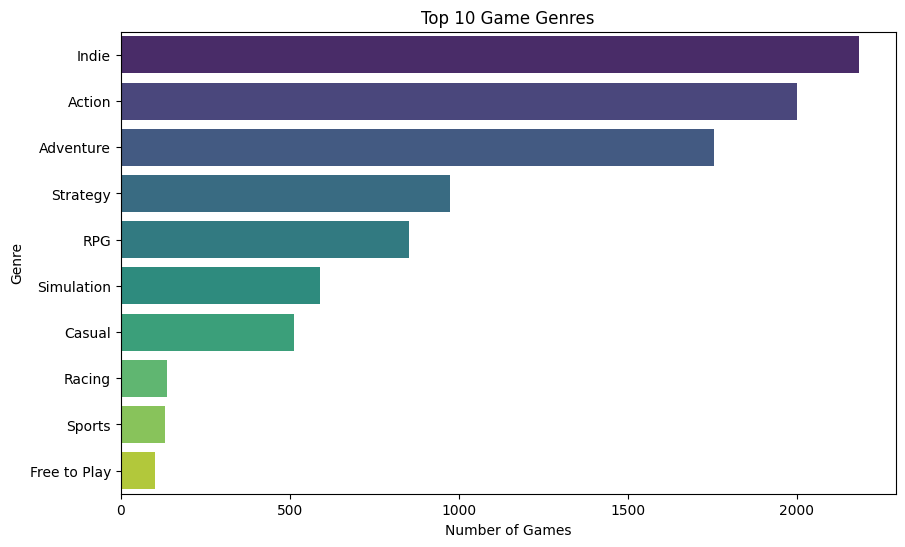

In [101]:
# Distribution of Well_Received
plt.figure(figsize=(6,4))
sns.countplot(x='Well_Received', data=df_filtered)
plt.title('Distribution of Well_Received Games')
plt.xlabel('Well Received (1=Yes, 0=No)')
plt.ylabel('Count')
plt.show()

# Histogram of Metacritic and User Scores
fig, axs = plt.subplots(1, 2, figsize=(12,4))

sns.histplot(df_filtered['Metacritic score'].dropna(), bins=30, kde=True, ax=axs[0])
axs[0].set_title('Distribution of Metacritic Scores')

sns.histplot(df_filtered['User score'].dropna(), bins=30, kde=True, ax=axs[1])
axs[1].set_title('Distribution of User Scores')

plt.show()

# Scatter plot: Metacritic score vs User score
plt.figure(figsize=(7,5))
sns.scatterplot(x='Metacritic score', y='User score', hue='Well_Received', data=df_filtered, alpha=0.6)
plt.title('Metacritic vs User Score Colored by Well_Received')
plt.show()

# Boxplots of Metacritic and User Scores by Well_Received
fig, axs = plt.subplots(1, 2, figsize=(12,5))

sns.boxplot(x='Well_Received', y='Metacritic score', data=df_filtered, ax=axs[0])
axs[0].set_title('Metacritic Scores by Well_Received')

sns.boxplot(x='Well_Received', y='User score', data=df_filtered, ax=axs[1])
axs[1].set_title('User Scores by Well_Received')

plt.show()

# Top 10 genres count plot
all_genres = df_filtered['Genres'].dropna().str.split(',').explode()
top_genres = all_genres.value_counts().nlargest(10)

plt.figure(figsize=(10,6))
sns.barplot(x=top_genres.values, y=top_genres.index, palette='viridis')
plt.title('Top 10 Game Genres')
plt.xlabel('Number of Games')
plt.ylabel('Genre')
plt.show()

In [102]:
# Explode genres into individual rows
df_genres = df_filtered[['Genres', 'Well_Received']].dropna().copy()
df_genres = df_genres.assign(Genre=df_genres['Genres'].str.split(',')).explode('Genre')

# Stripping whitespace just in case
df_genres['Genre'] = df_genres['Genre'].str.strip()

# Group by Genre and calculate proportion of well received
genre_rank = df_genres.groupby('Genre')['Well_Received'].agg(['mean', 'count']).reset_index()

# Rename columns for clarity
genre_rank.columns = ['Genre', 'Well_Received_Rate', 'Count']

# Sort by Well_Received_Rate descending
genre_rank = genre_rank.sort_values(by='Well_Received_Rate', ascending=False)

print(genre_rank.head(20))  # Top 20 genres by well received rate

                    Genre  Well_Received_Rate  Count
15                Unknown            0.800000      5
1               Adventure            0.633979   1754
9                     RPG            0.630715    853
6                   Indie            0.620705   2183
0                  Action            0.610695   2001
14               Strategy            0.606776    974
10                 Racing            0.605839    137
2                  Casual            0.602339    513
3            Early Access            0.600000      5
13                 Sports            0.583333    132
12             Simulation            0.558574    589
7   Massively Multiplayer            0.533333     75
4            Free to Play            0.504854    103
11         Sexual Content            0.500000      2
8                  Nudity            0.333333      3
16                Violent            0.285714      7
5                    Gore            0.000000      1


<ipython-input-103-3be695d2cc06>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=genre_rank.head(20), x='Well_Received_Rate', y='Genre', palette='coolwarm')


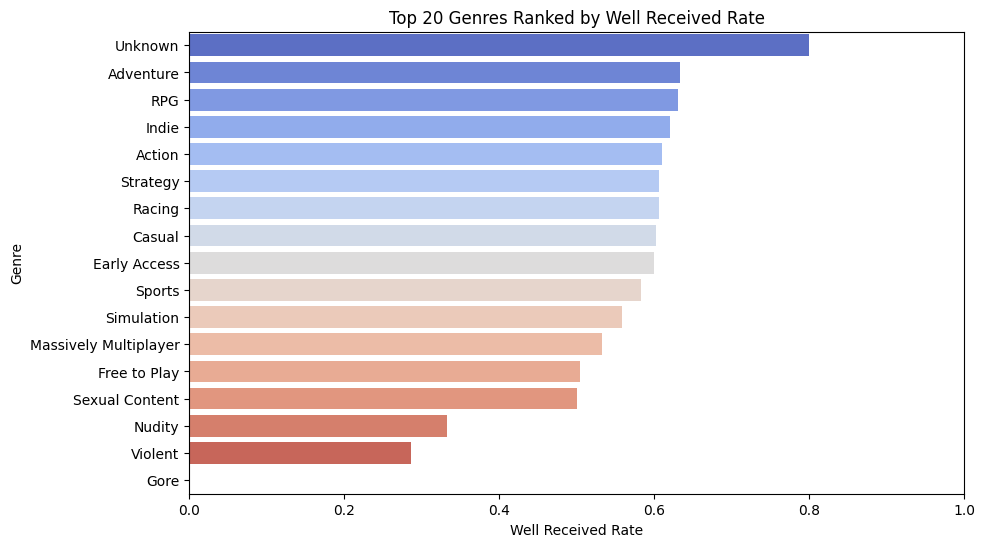

In [103]:
plt.figure(figsize=(10,6))
sns.barplot(data=genre_rank.head(20), x='Well_Received_Rate', y='Genre', palette='coolwarm')
plt.title('Top 20 Genres Ranked by Well Received Rate')
plt.xlabel('Well Received Rate')
plt.ylabel('Genre')
plt.xlim(0,1)
plt.show()

### Feature Engineering

In [104]:
# Copy the filtered dataframe
df_feat = df_filtered.copy()

# Extract release year & game age
df_feat['Release Year'] = df_feat['Release date'].dt.year
df_feat['Game Age'] = 2025 - df_feat['Release Year']

# Platform encoding
df_feat['Windows'] = df_feat['Windows'].astype(int)
df_feat['Mac'] = df_feat['Mac'].astype(int)
df_feat['Linux'] = df_feat['Linux'].astype(int)

# Price binning
def price_bin(price):
    if price == 0:
        return 'Free'
    elif price <= 10:
        return 'Low'
    elif price <= 30:
        return 'Medium'
    else:
        return 'High'

df_feat['Price_bin'] = df_feat['Price'].apply(price_bin)

# MultiLabelBinarizer on Genres
df_feat['Genres_list'] = df_feat['Genres'].str.split(',').apply(lambda x: [g.strip() for g in x] if isinstance(x, list) else [])

mlb_genres = MultiLabelBinarizer()
genres_encoded = mlb_genres.fit_transform(df_feat['Genres_list'])
genres_df = pd.DataFrame(genres_encoded, columns=[f"Genre_{g}" for g in mlb_genres.classes_], index=df_feat.index)

### Encoding/Scaling/Imputing

In [105]:
# One-hot encode Price_bin
price_dummies = pd.get_dummies(df_feat['Price_bin'], prefix='Price')

# Combine all features
features = pd.concat([
    df_feat[['Metacritic score', 'User score', 'Peak CCU', 'Achievements', 'Recommendations',
             'Average playtime forever', 'Average playtime two weeks', 'Median playtime forever', 'Median playtime two weeks',
             'Windows', 'Mac', 'Linux', 'Game Age']],
    genres_df,
    price_dummies
], axis=1)

# Scaling numeric features
numeric_cols = ['Metacritic score', 'User score', 'Peak CCU', 'Achievements', 'Recommendations',
                'Average playtime forever', 'Average playtime two weeks', 'Median playtime forever', 'Median playtime two weeks',
                'Game Age']

scaler = StandardScaler()

# Imputing for NaN values
for col in numeric_cols:
    median_val = features[col].median()
    features[col] = features[col].fillna(median_val)

features[numeric_cols] = scaler.fit_transform(features[numeric_cols])

print(features.head())

         Metacritic score  User score  Peak CCU  Achievements  \
1026420         -1.044758    0.003019 -0.402712      0.015186   
22670           -0.855138    0.003019 -0.402712     -0.363682   
231330          -1.898047    0.003019 -0.402712      0.303848   
897820           1.041060    0.003019 -0.402712     -0.417806   
12140            1.515110    0.003019  2.513937     -0.598219   

         Recommendations  Average playtime forever  \
1026420        -0.135487                 -0.317653   
22670          -0.137588                 -0.330550   
231330         -0.124939                 -0.173548   
897820         -0.129747                 -0.308682   
12140          -0.013337                 -0.261021   

         Average playtime two weeks  Median playtime forever  \
1026420                   -0.164246                -0.288140   
22670                     -0.164246                -0.353554   
231330                    -0.164246                 0.032291   
897820                    -0

<ipython-input-105-dec7ca92867d>:23: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  features[col] = features[col].fillna(median_val)
<ipython-input-105-dec7ca92867d>:23: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  features[col] = features[col].fillna(median_val)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/extmath.py:1101: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
/usr/local/lib/python3.11/dist-packages/sklearn/utils/extmath.py:1106: RuntimeWarning: invalid value encountered

In [106]:
# price is showing as true/false instead of 0/1
price_dummies = pd.get_dummies(df_feat['Price_bin'], prefix='Price').astype(int)

# Double checking target shape
print(features.shape, target.shape)

(4000, 33) (4000,)


In [111]:
# Target shape and features shape is good, now to continue fixing price to be binary vs true/false

# Regenerate dummy columns as ints
price_dummies = pd.get_dummies(df_feat['Price_bin'], prefix='Price').astype(int)

# Rebuild features from scratch
features = pd.concat([
    df_feat[['Metacritic score', 'User score', 'Peak CCU', 'Achievements', 'Recommendations',
             'Average playtime forever', 'Average playtime two weeks', 'Median playtime forever', 'Median playtime two weeks',
             'Windows', 'Mac', 'Linux', 'Game Age']],
    genres_df,
    price_dummies
], axis=1)

# Re-scale numeric features
numeric_cols = ['Metacritic score', 'User score', 'Peak CCU', 'Achievements', 'Recommendations',
                'Average playtime forever', 'Average playtime two weeks', 'Median playtime forever', 'Median playtime two weeks',
                'Game Age']

# Imputing for NaN values
for col in numeric_cols:
    if features[col].isna().any():
        median_val = features[col].median()
        features[col] = features[col].fillna(median_val).infer_objects(copy=False)

features[numeric_cols] = StandardScaler().fit_transform(features[numeric_cols])

print(features[['Price_Free', 'Price_Low', 'Price_Medium']].head())
print(features.dtypes.tail(5))  # double-check they're int64

         Price_Free  Price_Low  Price_Medium
1026420           1          0             0
22670             1          0             0
231330            1          0             0
897820            1          0             0
12140             1          0             0
Genre_Unknown    int64
Genre_Violent    int64
Price_Free       int64
Price_Low        int64
Price_Medium     int64
dtype: object


<ipython-input-111-9066690f0f8b>:24: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  features[col] = features[col].fillna(median_val).infer_objects(copy=False)
<ipython-input-111-9066690f0f8b>:24: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  features[col] = features[col].fillna(median_val).infer_objects(copy=False)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/extmath.py:1101: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
/usr/local/lib/python3.11/dist-packages/sklearn/utils/extmat

### Modeling

In [113]:
# Create train/test splits
X_train, X_test, y_train, y_test = train_test_split(
    features, target, test_size=0.2, random_state=42, stratify=target
)

In [115]:
# Creating random forest model
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

print(confusion_matrix(y_test, y_pred_rf))
print(classification_report(y_test, y_pred_rf))

[[260  51]
 [  6 483]]
              precision    recall  f1-score   support

           0       0.98      0.84      0.90       311
           1       0.90      0.99      0.94       489

    accuracy                           0.93       800
   macro avg       0.94      0.91      0.92       800
weighted avg       0.93      0.93      0.93       800



                       feature  importance
0             Metacritic score    0.592607
4              Recommendations    0.100150
5     Average playtime forever    0.058905
7      Median playtime forever    0.053856
3                 Achievements    0.047051
6   Average playtime two weeks    0.019116
8    Median playtime two weeks    0.018384
19                 Genre_Indie    0.010104
10                         Mac    0.009905
1                   User score    0.009826
14             Genre_Adventure    0.009347
13                Genre_Action    0.009110
27              Genre_Strategy    0.008382
2                     Peak CCU    0.008099
11                       Linux    0.008069


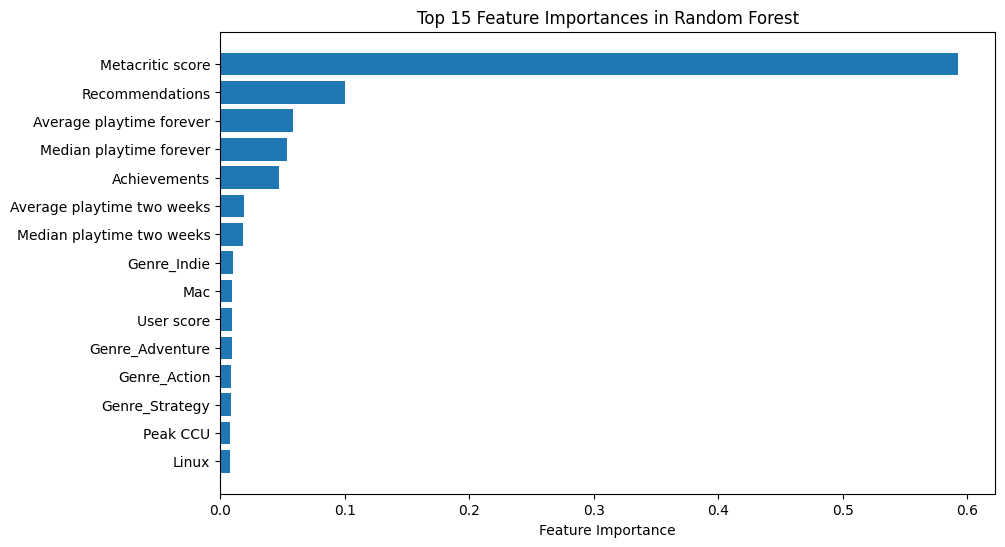

In [116]:
# Defining feature importances
importances = rf.feature_importances_

# Create a DataFrame with feature names and their importances
feature_importances = pd.DataFrame({
    'feature': features.columns,
    'importance': importances
})

# Sort features by importance descending
feature_importances = feature_importances.sort_values(by='importance', ascending=False)

# Display the top 15 most important features
print(feature_importances.head(15))

# Plot the top 15 feature importances
plt.figure(figsize=(10,6))
plt.barh(feature_importances['feature'][:15][::-1], feature_importances['importance'][:15][::-1])
plt.xlabel('Feature Importance')
plt.title('Top 15 Feature Importances in Random Forest')
plt.show()

The feature importance results are pretty telling. The Metacritic score stands out as the most influential factor by far, accounting for nearly 60% of the importance, which makes sense since it’s a solid overall measure of game quality. Recommendations and the different playtime metrics also carry a lot of weight, showing that how much and how long people play a game really reflects its reception. Achievements add some value too, likely because they hint at player engagement or game depth. Genre tags like Indie, Adventure, Action, and Strategy matter but to a lesser degree, which suggests the type of game influences how well it’s received. Platform indicators like Mac and Linux have a small effect, probably reflecting differences in player bases on those systems. Overall, it’s clear that a mix of quality scores, player activity, and game characteristics all contribute to predicting if a game is well received.